In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from skimage.util import view_as_windows
from skimage.util import view_as_blocks
from tqdm import tqdm
from scipy.io import loadmat
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
img_data = loadmat("/content/drive/MyDrive/Hemanth/Dataset/Indian_pines_corrected.mat")['indian_pines_corrected'].astype("float32")

In [ ]:
mean = img_data.mean()
std = img_data.std()

transform1 = T.Compose([ T.ToTensor(),
                        T.Normalize(mean, std)
                        ])

print(img_data.shape," MIN: ",img_data.min(), " MAX: ", img_data.max())

img_data_tensor = transform1(img_data)

print(img_data_tensor.shape," MIN: ",img_data_tensor.min(), " MAX: ", img_data_tensor.max())


(145, 145, 200)  MIN:  955.0  MAX:  9604.0
torch.Size([200, 145, 145])  MIN:  tensor(-1.0660)  MAX:  tensor(4.3657)


In [ ]:
# Normalizationon img_data
img_data_normalized = (img_data - mean) / std
print(img_data_normalized.shape," MIN: ",img_data_normalized.min(), " MAX: ", img_data_normalized.max())

(145, 145, 200)  MIN:  -1.0659719  MAX:  4.3656573


# WITHOUT PCA

In [ ]:
# # Flatten the image data to apply PCA
# flattened_img_data = img_data_normalized.reshape(-1, img_data_normalized.shape[-1]) # (21025, 200)

# # Apply PCA to reduce dimensionality
# pca = PCA(n_components=10)
# pca.fit(flattened_img_data)

# # Get the top ten principal components
# top_ten_components = pca.components_

# # Transform the original image data using the top ten components
# transformed_img_data = pca.transform(flattened_img_data)

# # Reshape the transformed data back to the original shape
# transformed_img_data = transformed_img_data.reshape(img_data_normalized.shape[0], img_data_normalized.shape[1], -1)

# # Print the shapes of the transformed data and top components
# print("Transformed Image Data Shape:", transformed_img_data.shape)
# print("Top Ten Components Shape:", top_ten_components.shape)


Transformed Image Data Shape: (145, 145, 10)
Top Ten Components Shape: (10, 200)


In [ ]:
transformed_img_data = img_data_normalized
transformed_img_data.shape

(145, 145, 200)

# Divide image into patches

In [ ]:
patch_size = 5

total_img_patches = view_as_windows(transformed_img_data, (patch_size, patch_size,transformed_img_data.shape[2]), step=1)
total_img_patches = total_img_patches.reshape(-1, patch_size, patch_size, transformed_img_data.shape[2])

total_img_patches_tensor = torch.tensor(total_img_patches, dtype=torch.float32).to(device)

print("Image Patches Shape:", total_img_patches_tensor.shape)


Image Patches Shape: torch.Size([19881, 5, 5, 200])


# Select few patches for training

In [ ]:
num_patches = 19712

selected_indices = torch.randperm(total_img_patches_tensor.size(0))[:num_patches]

img_patches = total_img_patches_tensor[selected_indices]
img_patches_cpu = img_patches.cpu().numpy()

print("MIN:", img_patches_cpu.min(), "Max:", img_patches_cpu.max())

print("Image Patches Shape:", img_patches_cpu.shape)

MIN: -1.0659719 Max: 4.3656573
Image Patches Shape: (19712, 5, 5, 200)


In [ ]:
class HyperX(data.Dataset):

    def __init__(self, img_patches):
        super(HyperX, self).__init__()
        self.data = img_patches

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        data = self.data[i].astype(np.float32)
        data_tensor = torch.tensor(data).to(device)
        return data_tensor

In [ ]:
dataset = HyperX(img_patches_cpu)

batch_size = 256

# Define data loader
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
z_dim = 200
channels = img_patches_cpu.shape[3]
height = img_patches_cpu.shape[2]
width = img_patches_cpu.shape[1]
print(channels, height, width)

200 5 5


# Generator

In [25]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.ConvTranspose2d(2*channels, 512, 3, 1, 1) #5x5
    self.conv2 = nn.ConvTranspose2d(512, 256, 3, 1, 1) #5x5
    self.conv3 = nn.ConvTranspose2d(256, 128, 3, 1, 1) #5x5
    self.conv4 = nn.ConvTranspose2d(128,  channels, 3, 1, 1) #5x5

    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)

  def forward(self, noise, condition):
    x = torch.cat([condition, noise], dim=1)
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.tanh(self.conv4(x))
    return x

G = Generator().to(device)
print(G)

Generator(
  (conv1): ConvTranspose2d(400, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): ConvTranspose2d(128, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [26]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(2*channels, 64, 4, 1, 1) #4x4
    self.conv2 = nn.Conv2d(64, 128, 4, 1, 1) #3x3
    self.conv3 = nn.Conv2d(128, 256, 3, 1, 1) #3x3
    self.conv4 = nn.Conv2d(256, 1, 3, 1, 0) #1x1

    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)

  def forward(self, real, fake):
    x = torch.cat([real, fake], dim=1)
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.bn2(x)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.bn3(x)
    x = torch.sigmoid(self.conv4(x) ).view(-1,1)
    return x

D = Discriminator().to(device)
print(D)

Discriminator(
  (conv1): Conv2d(400, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# TO LOAD MODEL AND PARAMETERS

In [ ]:
# G.load_state_dict(torch.load('/content/drive/MyDrive/Hemanth/model/generator_250ep.pth'))
# D.load_state_dict(torch.load('/content/drive/MyDrive/Hemanth/model/discriminator_250ep.pth'))

# # Load the optimizer states
# g_optimizer = optim.Adam(G.parameters(), lr=0.00001, betas=(0.5, 0.999))
# d_optimizer = optim.Adam(D.parameters(), lr=0.00001, betas=(0.5, 0.999))

# g_optimizer.load_state_dict(torch.load('/content/drive/MyDrive/Hemanth/model/generator_optimizer_250ep.pth'))
# d_optimizer.load_state_dict(torch.load('/content/drive/MyDrive/Hemanth/model/discriminator_optimizer_250ep.pth'))

# # Load additional parameters
# checkpoint = torch.load('/content/drive/MyDrive/Hemanth/model/training_params_250ep.pth')
# num_epochs = checkpoint['num_epochs']
# losses = checkpoint['losses']
# disDecs = checkpoint['disDecs']
# lambda_rmse = checkpoint['lambda_rmse']
# lambda_sam = checkpoint['lambda_sam']

# # Remove .to(device) for G and D above and shift them to GPU here
# G = G.to(device)
# D = D.to(device)

# Train the Discriminator and Generator

In [ ]:
# Define RMSE loss function
def rmse_loss(input, target):
    return torch.sqrt(F.mse_loss(input, target))

# Define SAM loss function
def sam_loss(input, target):
    input_norm = F.normalize(input.reshape(input.size(0), -1), dim=1)
    target_norm = F.normalize(target.reshape(target.size(0), -1), dim=1)
    return torch.acos((input_norm * target_norm).sum(dim=1)).mean()

In [27]:
bceloss = nn.BCELoss()

g_optimizer = optim.Adam(G.parameters(), lr = 0.00001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr = 0.00001, betas=(0.5, 0.999))

In [28]:
num_epochs = 250

losses = []
disDecs = []

lambda_rmse = 0.9
lambda_sam = 0.4

for epochi in range(num_epochs):
  for _,data in tqdm(enumerate(data_loader), total=len(data_loader)):

      real_images = data.permute(0,3,1,2).to(device)

      real_labels = torch.ones(batch_size,1).to(device)
      fake_labels = torch.zeros(batch_size,1).to(device)

      # Train Discriminator

      # Forward pass to test real images against real images
      pred_real = D(real_images,real_images)
      d_loss_real = bceloss(pred_real, real_labels)

      # forward pass to test fake images against real images
      noise = torch.randn(batch_size,channels,width,height).to(device)
      fake_images = G(noise, real_images)
      pred_fake = D(real_images, fake_images)
      d_loss_fake = bceloss(pred_fake,fake_labels)

      # Discriminator loss
      d_loss = d_loss_real + d_loss_fake

      # Backprop
      d_optimizer.zero_grad()
      d_loss.backward()
      d_optimizer.step()

      # Train Generator twice for once of discriminator
      for _ in range(2):
        # create fake images
        noise = torch.randn(batch_size,channels,width,height).to(device)
        fake_images = G(noise, real_images)
        pred_fake = D(real_images, fake_images)

        # Generator loss
        adversarial_loss = -torch.mean(D(fake_images, real_images))
        rmse_loss_value = rmse_loss(fake_images, real_images)
        sam_loss_value = sam_loss(fake_images, real_images)

        g_loss = adversarial_loss + lambda_rmse * rmse_loss_value + lambda_sam * sam_loss_value


        # backprop
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

  losses.append([d_loss.item(), g_loss.item()])

  d1 = torch.mean((pred_real>0.5).float().detach())
  d2 = torch.mean((pred_fake>0.5).float().detach())
  disDecs.append([d1,d2])

  print(f"Epoch [{epochi+1}/{num_epochs}], G Loss: {g_loss.item()},  D Real Loss: {d_loss_real.item()}, D Fake Loss: {d_loss_fake.item()}")

100%|██████████| 77/77 [00:07<00:00, 10.23it/s]


Epoch [1/250], G Loss: -0.1397170126438141,  D Real Loss: 0.010365936905145645, D Fake Loss: 0.010607964359223843


100%|██████████| 77/77 [00:04<00:00, 16.18it/s]


Epoch [2/250], G Loss: -0.36193105578422546,  D Real Loss: 0.0049748201854527, D Fake Loss: 0.004911052528768778


100%|██████████| 77/77 [00:04<00:00, 16.31it/s]


Epoch [3/250], G Loss: -0.47238659858703613,  D Real Loss: 0.0028141536749899387, D Fake Loss: 0.002553020603954792


100%|██████████| 77/77 [00:04<00:00, 16.59it/s]


Epoch [4/250], G Loss: -0.4901154637336731,  D Real Loss: 0.0019182474352419376, D Fake Loss: 0.001723962719552219


100%|██████████| 77/77 [00:04<00:00, 16.00it/s]


Epoch [5/250], G Loss: -0.5060369968414307,  D Real Loss: 0.001268049469217658, D Fake Loss: 0.001102284761145711


100%|██████████| 77/77 [00:04<00:00, 16.13it/s]


Epoch [6/250], G Loss: -0.5301116108894348,  D Real Loss: 0.0010577969951555133, D Fake Loss: 0.0008973422227427363


100%|██████████| 77/77 [00:04<00:00, 16.17it/s]


Epoch [7/250], G Loss: -0.5369722247123718,  D Real Loss: 0.0006226390250958502, D Fake Loss: 0.0005853548645973206


100%|██████████| 77/77 [00:04<00:00, 16.04it/s]


Epoch [8/250], G Loss: -0.5539188385009766,  D Real Loss: 0.0004692245274782181, D Fake Loss: 0.00040307577000930905


100%|██████████| 77/77 [00:04<00:00, 16.61it/s]


Epoch [9/250], G Loss: -0.5656495094299316,  D Real Loss: 0.0004861725610680878, D Fake Loss: 0.0004589649906847626


100%|██████████| 77/77 [00:04<00:00, 16.50it/s]


Epoch [10/250], G Loss: -0.5479203462600708,  D Real Loss: 0.00038300539017654955, D Fake Loss: 0.00032903661485761404


100%|██████████| 77/77 [00:04<00:00, 16.28it/s]


Epoch [11/250], G Loss: -0.5541850328445435,  D Real Loss: 0.00028936107992194593, D Fake Loss: 0.0002486483135726303


100%|██████████| 77/77 [00:04<00:00, 16.15it/s]


Epoch [12/250], G Loss: -0.557311475276947,  D Real Loss: 0.00031939410837367177, D Fake Loss: 0.00029056990751996636


100%|██████████| 77/77 [00:04<00:00, 15.97it/s]


Epoch [13/250], G Loss: -0.5772746801376343,  D Real Loss: 0.0001870533887995407, D Fake Loss: 0.0001754041586536914


100%|██████████| 77/77 [00:04<00:00, 16.38it/s]


Epoch [14/250], G Loss: -0.5888680219650269,  D Real Loss: 0.00020573190704453737, D Fake Loss: 0.00022258833632804453


100%|██████████| 77/77 [00:04<00:00, 16.48it/s]


Epoch [15/250], G Loss: -0.556146502494812,  D Real Loss: 0.00017299539467785507, D Fake Loss: 0.00014973380893934518


100%|██████████| 77/77 [00:04<00:00, 16.62it/s]


Epoch [16/250], G Loss: -0.5812290906906128,  D Real Loss: 0.00013768843200523406, D Fake Loss: 0.00012171619891887531


100%|██████████| 77/77 [00:04<00:00, 16.25it/s]


Epoch [17/250], G Loss: -0.5727664828300476,  D Real Loss: 0.00020214536925777793, D Fake Loss: 0.00016402872279286385


100%|██████████| 77/77 [00:04<00:00, 16.07it/s]


Epoch [18/250], G Loss: -0.5731176137924194,  D Real Loss: 0.00016514449089299887, D Fake Loss: 0.00013299143756739795


100%|██████████| 77/77 [00:04<00:00, 16.19it/s]


Epoch [19/250], G Loss: -0.5878899693489075,  D Real Loss: 0.00012401698040775955, D Fake Loss: 0.00012084671470802277


100%|██████████| 77/77 [00:04<00:00, 16.27it/s]


Epoch [20/250], G Loss: -0.5788050293922424,  D Real Loss: 8.16447936813347e-05, D Fake Loss: 7.426756201311946e-05


100%|██████████| 77/77 [00:04<00:00, 16.62it/s]


Epoch [21/250], G Loss: -0.5770382285118103,  D Real Loss: 8.108153269859031e-05, D Fake Loss: 6.910209776833653e-05


100%|██████████| 77/77 [00:04<00:00, 16.56it/s]


Epoch [22/250], G Loss: -0.5647058486938477,  D Real Loss: 0.00010104297689395025, D Fake Loss: 9.153331484412774e-05


100%|██████████| 77/77 [00:04<00:00, 15.93it/s]


Epoch [23/250], G Loss: -0.5801516175270081,  D Real Loss: 7.38483649911359e-05, D Fake Loss: 7.556557829957455e-05


100%|██████████| 77/77 [00:04<00:00, 16.21it/s]


Epoch [24/250], G Loss: -0.5820505619049072,  D Real Loss: 6.276735075516626e-05, D Fake Loss: 5.5773896747268736e-05


100%|██████████| 77/77 [00:04<00:00, 16.02it/s]


Epoch [25/250], G Loss: -0.5641669034957886,  D Real Loss: 5.562053411267698e-05, D Fake Loss: 5.515105294762179e-05


100%|██████████| 77/77 [00:04<00:00, 16.44it/s]


Epoch [26/250], G Loss: -0.5762739181518555,  D Real Loss: 6.952924013603479e-05, D Fake Loss: 6.094544005463831e-05


100%|██████████| 77/77 [00:04<00:00, 16.84it/s]


Epoch [27/250], G Loss: -0.5842801332473755,  D Real Loss: 5.476300430018455e-05, D Fake Loss: 4.735665424959734e-05


100%|██████████| 77/77 [00:04<00:00, 16.32it/s]


Epoch [28/250], G Loss: -0.5847923159599304,  D Real Loss: 4.275357787264511e-05, D Fake Loss: 4.031535718240775e-05


100%|██████████| 77/77 [00:04<00:00, 16.29it/s]


Epoch [29/250], G Loss: -0.5950148701667786,  D Real Loss: 4.494569657254033e-05, D Fake Loss: 3.740855026990175e-05


100%|██████████| 77/77 [00:04<00:00, 16.31it/s]


Epoch [30/250], G Loss: -0.5786865949630737,  D Real Loss: 4.030780473840423e-05, D Fake Loss: 3.373646904947236e-05


100%|██████████| 77/77 [00:04<00:00, 16.31it/s]


Epoch [31/250], G Loss: -0.5758420825004578,  D Real Loss: 3.6807239666813985e-05, D Fake Loss: 3.350091719767079e-05


100%|██████████| 77/77 [00:04<00:00, 16.48it/s]


Epoch [32/250], G Loss: -0.5859696269035339,  D Real Loss: 4.379878373583779e-05, D Fake Loss: 3.85931707569398e-05


100%|██████████| 77/77 [00:04<00:00, 16.44it/s]


Epoch [33/250], G Loss: -0.5789473652839661,  D Real Loss: 4.804610216524452e-05, D Fake Loss: 4.940701910527423e-05


100%|██████████| 77/77 [00:04<00:00, 16.52it/s]


Epoch [34/250], G Loss: -0.5885473489761353,  D Real Loss: 3.05216817650944e-05, D Fake Loss: 2.942410901596304e-05


100%|██████████| 77/77 [00:04<00:00, 16.19it/s]


Epoch [35/250], G Loss: -0.5902727246284485,  D Real Loss: 3.910255691152997e-05, D Fake Loss: 3.077550354646519e-05


100%|██████████| 77/77 [00:04<00:00, 16.38it/s]


Epoch [36/250], G Loss: -0.6102554202079773,  D Real Loss: 3.233932875446044e-05, D Fake Loss: 2.992641384480521e-05


100%|██████████| 77/77 [00:04<00:00, 16.58it/s]


Epoch [37/250], G Loss: -0.5820289850234985,  D Real Loss: 2.498962203389965e-05, D Fake Loss: 2.3444790713256225e-05


100%|██████████| 77/77 [00:04<00:00, 16.88it/s]


Epoch [38/250], G Loss: -0.5870376229286194,  D Real Loss: 2.3576300009153783e-05, D Fake Loss: 2.235361716884654e-05


100%|██████████| 77/77 [00:04<00:00, 17.18it/s]


Epoch [39/250], G Loss: -0.5906094312667847,  D Real Loss: 2.2823143808636814e-05, D Fake Loss: 2.0780236809514463e-05


100%|██████████| 77/77 [00:04<00:00, 16.87it/s]


Epoch [40/250], G Loss: -0.591907799243927,  D Real Loss: 1.905472163343802e-05, D Fake Loss: 1.64968914759811e-05


100%|██████████| 77/77 [00:04<00:00, 16.48it/s]


Epoch [41/250], G Loss: -0.5825453400611877,  D Real Loss: 2.1688298147637397e-05, D Fake Loss: 2.0573857909766957e-05


100%|██████████| 77/77 [00:04<00:00, 16.72it/s]


Epoch [42/250], G Loss: -0.5809718370437622,  D Real Loss: 1.2626070201804396e-05, D Fake Loss: 1.1580928912735544e-05


100%|██████████| 77/77 [00:04<00:00, 16.64it/s]


Epoch [43/250], G Loss: -0.5884863138198853,  D Real Loss: 2.2056188754504547e-05, D Fake Loss: 1.666550087975338e-05


100%|██████████| 77/77 [00:04<00:00, 17.15it/s]


Epoch [44/250], G Loss: -0.5928048491477966,  D Real Loss: 2.7632009732769802e-05, D Fake Loss: 2.534592385927681e-05


100%|██████████| 77/77 [00:04<00:00, 17.26it/s]


Epoch [45/250], G Loss: -0.5834503173828125,  D Real Loss: 2.702525853237603e-05, D Fake Loss: 2.5209399609593675e-05


100%|██████████| 77/77 [00:04<00:00, 16.54it/s]


Epoch [46/250], G Loss: -0.6090131998062134,  D Real Loss: 1.712717676127795e-05, D Fake Loss: 1.891867577796802e-05


100%|██████████| 77/77 [00:04<00:00, 16.68it/s]


Epoch [47/250], G Loss: -0.5993778109550476,  D Real Loss: 2.3208343918668106e-05, D Fake Loss: 2.0751700503751636e-05


100%|██████████| 77/77 [00:04<00:00, 16.66it/s]


Epoch [48/250], G Loss: -0.5946506857872009,  D Real Loss: 1.6794463590485975e-05, D Fake Loss: 1.3673476132680662e-05


100%|██████████| 77/77 [00:04<00:00, 16.53it/s]


Epoch [49/250], G Loss: -0.589505136013031,  D Real Loss: 1.4313844985736068e-05, D Fake Loss: 1.2998160855204333e-05


100%|██████████| 77/77 [00:04<00:00, 17.30it/s]


Epoch [50/250], G Loss: -0.587534487247467,  D Real Loss: 1.2153894203947857e-05, D Fake Loss: 1.0839733477041591e-05


100%|██████████| 77/77 [00:04<00:00, 17.06it/s]


Epoch [51/250], G Loss: -0.5920003652572632,  D Real Loss: 8.568712473788764e-06, D Fake Loss: 7.691355676797684e-06


100%|██████████| 77/77 [00:04<00:00, 16.61it/s]


Epoch [52/250], G Loss: -0.5846307873725891,  D Real Loss: 9.06043715076521e-06, D Fake Loss: 8.160408469848335e-06


100%|██████████| 77/77 [00:04<00:00, 16.48it/s]


Epoch [53/250], G Loss: -0.5944287776947021,  D Real Loss: 1.4672162251372356e-05, D Fake Loss: 1.4174192983773537e-05


100%|██████████| 77/77 [00:04<00:00, 16.46it/s]


Epoch [54/250], G Loss: -0.6020681262016296,  D Real Loss: 8.704208084964193e-06, D Fake Loss: 9.173779289994854e-06


100%|██████████| 77/77 [00:04<00:00, 16.73it/s]


Epoch [55/250], G Loss: -0.5790981650352478,  D Real Loss: 1.169807819678681e-05, D Fake Loss: 1.1713887943187729e-05


100%|██████████| 77/77 [00:04<00:00, 17.07it/s]


Epoch [56/250], G Loss: -0.5838214755058289,  D Real Loss: 6.780992862331914e-06, D Fake Loss: 6.277705324464478e-06


100%|██████████| 77/77 [00:04<00:00, 17.12it/s]


Epoch [57/250], G Loss: -0.5959829688072205,  D Real Loss: 1.3081838005746249e-05, D Fake Loss: 1.2057272215315606e-05


100%|██████████| 77/77 [00:04<00:00, 16.77it/s]


Epoch [58/250], G Loss: -0.599553108215332,  D Real Loss: 8.716335287317634e-06, D Fake Loss: 7.654553883185145e-06


100%|██████████| 77/77 [00:04<00:00, 16.47it/s]


Epoch [59/250], G Loss: -0.5833768248558044,  D Real Loss: 6.5127696871059015e-06, D Fake Loss: 6.598337222385453e-06


100%|██████████| 77/77 [00:04<00:00, 16.59it/s]


Epoch [60/250], G Loss: -0.5835304856300354,  D Real Loss: 9.186205716105178e-06, D Fake Loss: 9.268502253689803e-06


100%|██████████| 77/77 [00:04<00:00, 16.71it/s]


Epoch [61/250], G Loss: -0.5956587791442871,  D Real Loss: 9.953244443750009e-06, D Fake Loss: 1.0001538612414151e-05


100%|██████████| 77/77 [00:04<00:00, 17.02it/s]


Epoch [62/250], G Loss: -0.5872491598129272,  D Real Loss: 7.370560524577741e-06, D Fake Loss: 7.199336778285215e-06


100%|██████████| 77/77 [00:04<00:00, 17.14it/s]


Epoch [63/250], G Loss: -0.5993268489837646,  D Real Loss: 6.7707564994634595e-06, D Fake Loss: 6.803717951697763e-06


100%|██████████| 77/77 [00:04<00:00, 16.59it/s]


Epoch [64/250], G Loss: -0.6022981405258179,  D Real Loss: 7.389638994936831e-06, D Fake Loss: 8.053184501477517e-06


100%|██████████| 77/77 [00:04<00:00, 16.52it/s]


Epoch [65/250], G Loss: -0.5928344130516052,  D Real Loss: 6.146773557702545e-06, D Fake Loss: 6.145319730421761e-06


100%|██████████| 77/77 [00:04<00:00, 16.53it/s]


Epoch [66/250], G Loss: -0.5909438729286194,  D Real Loss: 6.60406567476457e-06, D Fake Loss: 5.535124728339724e-06


100%|██████████| 77/77 [00:04<00:00, 16.61it/s]


Epoch [67/250], G Loss: -0.5798591375350952,  D Real Loss: 5.4207876019063406e-06, D Fake Loss: 5.192605840420583e-06


100%|██████████| 77/77 [00:04<00:00, 17.24it/s]


Epoch [68/250], G Loss: -0.5909568071365356,  D Real Loss: 5.662015155394329e-06, D Fake Loss: 4.975328920409083e-06


100%|██████████| 77/77 [00:04<00:00, 16.87it/s]


Epoch [69/250], G Loss: -0.5916312336921692,  D Real Loss: 6.480197043856606e-06, D Fake Loss: 5.8764571804204024e-06


100%|██████████| 77/77 [00:04<00:00, 16.52it/s]


Epoch [70/250], G Loss: -0.5904580950737,  D Real Loss: 5.667600362357916e-06, D Fake Loss: 5.153864094609162e-06


100%|██████████| 77/77 [00:04<00:00, 16.62it/s]


Epoch [71/250], G Loss: -0.5940392017364502,  D Real Loss: 4.8447791414218955e-06, D Fake Loss: 4.124849510844797e-06


100%|██████████| 77/77 [00:04<00:00, 16.46it/s]


Epoch [72/250], G Loss: -0.583980143070221,  D Real Loss: 3.941839167964645e-06, D Fake Loss: 3.4909560326923383e-06


100%|██████████| 77/77 [00:04<00:00, 16.88it/s]


Epoch [73/250], G Loss: -0.6039554476737976,  D Real Loss: 4.298542535252636e-06, D Fake Loss: 4.0967897803056985e-06


100%|██████████| 77/77 [00:04<00:00, 17.13it/s]


Epoch [74/250], G Loss: -0.5823348760604858,  D Real Loss: 4.29574856752879e-06, D Fake Loss: 4.257050022715703e-06


100%|██████████| 77/77 [00:04<00:00, 17.08it/s]


Epoch [75/250], G Loss: -0.5994943380355835,  D Real Loss: 4.093648385605775e-06, D Fake Loss: 4.210000952298287e-06


100%|██████████| 77/77 [00:04<00:00, 16.56it/s]


Epoch [76/250], G Loss: -0.5848908424377441,  D Real Loss: 3.0607989174313843e-06, D Fake Loss: 2.8650192689383402e-06


100%|██████████| 77/77 [00:04<00:00, 16.41it/s]


Epoch [77/250], G Loss: -0.5920957326889038,  D Real Loss: 3.858956915792078e-06, D Fake Loss: 3.6509059100353625e-06


100%|██████████| 77/77 [00:04<00:00, 16.51it/s]


Epoch [78/250], G Loss: -0.5842806100845337,  D Real Loss: 2.696184765227372e-06, D Fake Loss: 2.387388349234243e-06


100%|██████████| 77/77 [00:04<00:00, 16.85it/s]


Epoch [79/250], G Loss: -0.5842258930206299,  D Real Loss: 2.7590485842665657e-06, D Fake Loss: 2.548033307903097e-06


100%|██████████| 77/77 [00:04<00:00, 17.06it/s]


Epoch [80/250], G Loss: -0.5842018127441406,  D Real Loss: 3.113420689260238e-06, D Fake Loss: 2.9486404855560977e-06


100%|██████████| 77/77 [00:04<00:00, 17.08it/s]


Epoch [81/250], G Loss: -0.6015596389770508,  D Real Loss: 2.7748815227823798e-06, D Fake Loss: 2.55854865827132e-06


100%|██████████| 77/77 [00:04<00:00, 16.65it/s]


Epoch [82/250], G Loss: -0.585091233253479,  D Real Loss: 2.6295945190213388e-06, D Fake Loss: 2.360979124205187e-06


100%|██████████| 77/77 [00:04<00:00, 16.69it/s]


Epoch [83/250], G Loss: -0.5838303565979004,  D Real Loss: 2.4829114408930764e-06, D Fake Loss: 2.38477832681383e-06


100%|██████████| 77/77 [00:04<00:00, 16.59it/s]


Epoch [84/250], G Loss: -0.6000654101371765,  D Real Loss: 4.776328751177061e-06, D Fake Loss: 4.797301244252594e-06


100%|██████████| 77/77 [00:04<00:00, 16.81it/s]


Epoch [85/250], G Loss: -0.5961521863937378,  D Real Loss: 2.6039838303404395e-06, D Fake Loss: 2.490923179720994e-06


100%|██████████| 77/77 [00:04<00:00, 17.29it/s]


Epoch [86/250], G Loss: -0.5900362730026245,  D Real Loss: 2.0423935893632006e-06, D Fake Loss: 2.0417103314684937e-06


100%|██████████| 77/77 [00:04<00:00, 17.04it/s]


Epoch [87/250], G Loss: -0.5917094349861145,  D Real Loss: 2.070333266601665e-06, D Fake Loss: 2.0313220829848433e-06


100%|██████████| 77/77 [00:04<00:00, 16.51it/s]


Epoch [88/250], G Loss: -0.5978918671607971,  D Real Loss: 1.8361051843385212e-06, D Fake Loss: 1.6936143083512434e-06


100%|██████████| 77/77 [00:04<00:00, 16.83it/s]


Epoch [89/250], G Loss: -0.5916934609413147,  D Real Loss: 2.749274699453963e-06, D Fake Loss: 2.6415234515297925e-06


100%|██████████| 77/77 [00:04<00:00, 16.39it/s]


Epoch [90/250], G Loss: -0.5839387774467468,  D Real Loss: 2.1830246623721905e-06, D Fake Loss: 1.9642257029772736e-06


100%|██████████| 77/77 [00:04<00:00, 17.01it/s]


Epoch [91/250], G Loss: -0.5835848450660706,  D Real Loss: 1.9492638330120826e-06, D Fake Loss: 1.7424508769181557e-06


100%|██████████| 77/77 [00:04<00:00, 17.11it/s]


Epoch [92/250], G Loss: -0.6050906777381897,  D Real Loss: 2.4084069991658907e-06, D Fake Loss: 2.047112275249674e-06


100%|██████████| 77/77 [00:04<00:00, 16.79it/s]


Epoch [93/250], G Loss: -0.5787551403045654,  D Real Loss: 1.8007158359978348e-06, D Fake Loss: 1.5749360500194598e-06


100%|██████████| 77/77 [00:04<00:00, 16.62it/s]


Epoch [94/250], G Loss: -0.5921081900596619,  D Real Loss: 1.6544969412279897e-06, D Fake Loss: 1.9081044229096733e-06


100%|██████████| 77/77 [00:04<00:00, 16.53it/s]


Epoch [95/250], G Loss: -0.5944228172302246,  D Real Loss: 2.0396012132550823e-06, D Fake Loss: 1.8758717033051653e-06


100%|██████████| 77/77 [00:04<00:00, 16.61it/s]


Epoch [96/250], G Loss: -0.6043718457221985,  D Real Loss: 1.9585761492635356e-06, D Fake Loss: 1.8322592723052367e-06


100%|██████████| 77/77 [00:04<00:00, 17.04it/s]


Epoch [97/250], G Loss: -0.60505211353302,  D Real Loss: 2.694333488761913e-06, D Fake Loss: 2.331375526409829e-06


100%|██████████| 77/77 [00:04<00:00, 16.91it/s]


Epoch [98/250], G Loss: -0.5873391032218933,  D Real Loss: 1.2991962421438075e-06, D Fake Loss: 1.240171059180284e-06


100%|██████████| 77/77 [00:04<00:00, 17.05it/s]


Epoch [99/250], G Loss: -0.5963243246078491,  D Real Loss: 1.5101414874152397e-06, D Fake Loss: 1.467865331505891e-06


100%|██████████| 77/77 [00:04<00:00, 16.44it/s]


Epoch [100/250], G Loss: -0.5888440608978271,  D Real Loss: 1.732262830955733e-06, D Fake Loss: 1.5974793541317922e-06


100%|██████████| 77/77 [00:04<00:00, 16.47it/s]


Epoch [101/250], G Loss: -0.5873993635177612,  D Real Loss: 1.1306267424515681e-06, D Fake Loss: 1.0718624707806157e-06


100%|██████████| 77/77 [00:04<00:00, 16.68it/s]


Epoch [102/250], G Loss: -0.5938231945037842,  D Real Loss: 1.4365671177074546e-06, D Fake Loss: 1.4197426025930326e-06


100%|██████████| 77/77 [00:04<00:00, 16.79it/s]


Epoch [103/250], G Loss: -0.5940413475036621,  D Real Loss: 1.3099073612465872e-06, D Fake Loss: 1.2202721109133563e-06


100%|██████████| 77/77 [00:04<00:00, 17.05it/s]


Epoch [104/250], G Loss: -0.5948189496994019,  D Real Loss: 1.2479736142267939e-06, D Fake Loss: 1.1532076769071864e-06


100%|██████████| 77/77 [00:04<00:00, 16.70it/s]


Epoch [105/250], G Loss: -0.6084566116333008,  D Real Loss: 1.5408758144985768e-06, D Fake Loss: 1.5821788110770285e-06


100%|██████████| 77/77 [00:04<00:00, 16.08it/s]


Epoch [106/250], G Loss: -0.5917230248451233,  D Real Loss: 1.115725353884045e-06, D Fake Loss: 1.1453431625341182e-06


100%|██████████| 77/77 [00:04<00:00, 16.47it/s]


Epoch [107/250], G Loss: -0.585568904876709,  D Real Loss: 1.1939569048990961e-06, D Fake Loss: 1.1418190979384235e-06


100%|██████████| 77/77 [00:04<00:00, 16.48it/s]


Epoch [108/250], G Loss: -0.610231876373291,  D Real Loss: 1.0007072432927089e-06, D Fake Loss: 1.112383984036569e-06


100%|██████████| 77/77 [00:04<00:00, 16.93it/s]


Epoch [109/250], G Loss: -0.5988951325416565,  D Real Loss: 9.271325325244106e-07, D Fake Loss: 9.196452310789027e-07


100%|██████████| 77/77 [00:04<00:00, 16.83it/s]


Epoch [110/250], G Loss: -0.5849587917327881,  D Real Loss: 8.959328852142789e-07, D Fake Loss: 8.581580459576799e-07


100%|██████████| 77/77 [00:04<00:00, 16.43it/s]


Epoch [111/250], G Loss: -0.5823315382003784,  D Real Loss: 7.613567731823423e-07, D Fake Loss: 7.747228778498538e-07


100%|██████████| 77/77 [00:04<00:00, 16.37it/s]


Epoch [112/250], G Loss: -0.5817103385925293,  D Real Loss: 7.380734814432799e-07, D Fake Loss: 6.980688453950279e-07


100%|██████████| 77/77 [00:04<00:00, 16.11it/s]


Epoch [113/250], G Loss: -0.5957062244415283,  D Real Loss: 5.406329819379607e-07, D Fake Loss: 5.347869773686398e-07


100%|██████████| 77/77 [00:04<00:00, 16.18it/s]


Epoch [114/250], G Loss: -0.5843532085418701,  D Real Loss: 1.5064192666613963e-06, D Fake Loss: 1.4023397625351208e-06


100%|██████████| 77/77 [00:04<00:00, 16.75it/s]


Epoch [115/250], G Loss: -0.6063259840011597,  D Real Loss: 9.257356055059063e-07, D Fake Loss: 1.0119264288732666e-06


100%|██████████| 77/77 [00:04<00:00, 16.63it/s]


Epoch [116/250], G Loss: -0.5805864334106445,  D Real Loss: 8.991930258162029e-07, D Fake Loss: 8.75154398727318e-07


100%|██████████| 77/77 [00:04<00:00, 16.41it/s]


Epoch [117/250], G Loss: -0.5993214845657349,  D Real Loss: 1.571616621731664e-06, D Fake Loss: 1.273943780688569e-06


100%|██████████| 77/77 [00:04<00:00, 16.14it/s]


Epoch [118/250], G Loss: -0.5943589806556702,  D Real Loss: 8.209615884879895e-07, D Fake Loss: 8.079493909463054e-07


100%|██████████| 77/77 [00:04<00:00, 16.32it/s]


Epoch [119/250], G Loss: -0.5785326361656189,  D Real Loss: 7.73929741626489e-07, D Fake Loss: 7.334402880587731e-07


100%|██████████| 77/77 [00:04<00:00, 16.40it/s]


Epoch [120/250], G Loss: -0.5795938968658447,  D Real Loss: 4.7078370357667154e-07, D Fake Loss: 4.564511186799791e-07


100%|██████████| 77/77 [00:04<00:00, 16.53it/s]


Epoch [121/250], G Loss: -0.6015769839286804,  D Real Loss: 8.228241199503827e-07, D Fake Loss: 7.228032927741879e-07


100%|██████████| 77/77 [00:04<00:00, 16.79it/s]


Epoch [122/250], G Loss: -0.5926524996757507,  D Real Loss: 6.258491112021147e-07, D Fake Loss: 6.217609325176454e-07


100%|██████████| 77/77 [00:04<00:00, 16.18it/s]


Epoch [123/250], G Loss: -0.5926768183708191,  D Real Loss: 6.398190635081846e-07, D Fake Loss: 6.264547209866578e-07


100%|██████████| 77/77 [00:04<00:00, 16.12it/s]


Epoch [124/250], G Loss: -0.5846716165542603,  D Real Loss: 6.062913371351897e-07, D Fake Loss: 6.508928436232964e-07


100%|██████████| 77/77 [00:04<00:00, 16.06it/s]


Epoch [125/250], G Loss: -0.5909490585327148,  D Real Loss: 5.858022404936492e-07, D Fake Loss: 5.933845841354923e-07


100%|██████████| 77/77 [00:04<00:00, 16.22it/s]


Epoch [126/250], G Loss: -0.5969903469085693,  D Real Loss: 6.468039828178007e-07, D Fake Loss: 6.12744429417944e-07


100%|██████████| 77/77 [00:04<00:00, 16.60it/s]


Epoch [127/250], G Loss: -0.6048711538314819,  D Real Loss: 4.591421998156875e-07, D Fake Loss: 4.856932491748012e-07


100%|██████████| 77/77 [00:04<00:00, 16.60it/s]


Epoch [128/250], G Loss: -0.5827032327651978,  D Real Loss: 4.20957917413034e-07, D Fake Loss: 4.079467998963082e-07


100%|██████████| 77/77 [00:04<00:00, 16.05it/s]


Epoch [129/250], G Loss: -0.6005880832672119,  D Real Loss: 4.456380793271819e-07, D Fake Loss: 4.2475622308302263e-07


100%|██████████| 77/77 [00:04<00:00, 16.24it/s]


Epoch [130/250], G Loss: -0.6036214828491211,  D Real Loss: 5.937185960647184e-07, D Fake Loss: 5.616381031359197e-07


100%|██████████| 77/77 [00:04<00:00, 16.03it/s]


Epoch [131/250], G Loss: -0.5939525961875916,  D Real Loss: 4.461036837710708e-07, D Fake Loss: 4.826817416869744e-07


100%|██████████| 77/77 [00:04<00:00, 16.48it/s]


Epoch [132/250], G Loss: -0.5802789926528931,  D Real Loss: 3.827736918537994e-07, D Fake Loss: 3.946443598579208e-07


100%|██████████| 77/77 [00:04<00:00, 16.47it/s]


Epoch [133/250], G Loss: -0.5835345983505249,  D Real Loss: 3.2549732509323803e-07, D Fake Loss: 3.1561080504616257e-07


100%|██████████| 77/77 [00:04<00:00, 16.83it/s]


Epoch [134/250], G Loss: -0.6039468050003052,  D Real Loss: 3.231689902349899e-07, D Fake Loss: 3.3459781434430624e-07


100%|██████████| 77/77 [00:04<00:00, 16.34it/s]


Epoch [135/250], G Loss: -0.5843983888626099,  D Real Loss: 3.1199311933960416e-07, D Fake Loss: 3.2785436587801087e-07


100%|██████████| 77/77 [00:04<00:00, 16.01it/s]


Epoch [136/250], G Loss: -0.5945537686347961,  D Real Loss: 2.663583131834457e-07, D Fake Loss: 2.7389285151002696e-07


100%|██████████| 77/77 [00:04<00:00, 16.27it/s]


Epoch [137/250], G Loss: -0.5985293984413147,  D Real Loss: 5.085024668005644e-07, D Fake Loss: 4.780654307978693e-07


100%|██████████| 77/77 [00:04<00:00, 16.25it/s]


Epoch [138/250], G Loss: -0.5857922434806824,  D Real Loss: 2.779998453661392e-07, D Fake Loss: 2.5962646077459794e-07


100%|██████████| 77/77 [00:04<00:00, 16.61it/s]


Epoch [139/250], G Loss: -0.5885610580444336,  D Real Loss: 3.539027488841384e-07, D Fake Loss: 3.822136420694733e-07


100%|██████████| 77/77 [00:04<00:00, 16.39it/s]


Epoch [140/250], G Loss: -0.6005814075469971,  D Real Loss: 3.068709020226379e-07, D Fake Loss: 2.9286445624165935e-07


100%|██████████| 77/77 [00:04<00:00, 16.00it/s]


Epoch [141/250], G Loss: -0.5943165421485901,  D Real Loss: 2.6077037773575285e-07, D Fake Loss: 2.6641123440640513e-07


100%|██████████| 77/77 [00:04<00:00, 16.12it/s]


Epoch [142/250], G Loss: -0.5970287919044495,  D Real Loss: 3.3155100709336693e-07, D Fake Loss: 3.2366585855925223e-07


100%|██████████| 77/77 [00:04<00:00, 16.04it/s]


Epoch [143/250], G Loss: -0.5897551774978638,  D Real Loss: 2.435409101053665e-07, D Fake Loss: 2.512485366423789e-07


100%|██████████| 77/77 [00:04<00:00, 16.53it/s]


Epoch [144/250], G Loss: -0.604636549949646,  D Real Loss: 2.84984878362593e-07, D Fake Loss: 2.699551373552822e-07


100%|██████████| 77/77 [00:04<00:00, 16.68it/s]


Epoch [145/250], G Loss: -0.5855737924575806,  D Real Loss: 1.8393623690826644e-07, D Fake Loss: 1.6815985759421892e-07


100%|██████████| 77/77 [00:04<00:00, 16.17it/s]


Epoch [146/250], G Loss: -0.5802346467971802,  D Real Loss: 2.4447223267998197e-07, D Fake Loss: 2.529718301502726e-07


100%|██████████| 77/77 [00:04<00:00, 16.10it/s]


Epoch [147/250], G Loss: -0.6063626408576965,  D Real Loss: 1.8998983364326705e-07, D Fake Loss: 1.8745289764865447e-07


100%|██████████| 77/77 [00:04<00:00, 15.95it/s]


Epoch [148/250], G Loss: -0.5981239080429077,  D Real Loss: 4.0791954347696446e-07, D Fake Loss: 4.0806608581078763e-07


100%|██████████| 77/77 [00:04<00:00, 16.20it/s]


Epoch [149/250], G Loss: -0.5878117680549622,  D Real Loss: 3.0966486974648433e-07, D Fake Loss: 3.3712532854224264e-07


100%|██████████| 77/77 [00:04<00:00, 16.64it/s]


Epoch [150/250], G Loss: -0.5981288552284241,  D Real Loss: 3.1013058787721093e-07, D Fake Loss: 3.075992367485014e-07


100%|██████████| 77/77 [00:04<00:00, 16.49it/s]


Epoch [151/250], G Loss: -0.599625825881958,  D Real Loss: 2.1792953930344083e-07, D Fake Loss: 2.0242680420778925e-07


100%|██████████| 77/77 [00:04<00:00, 16.22it/s]


Epoch [152/250], G Loss: -0.5975841283798218,  D Real Loss: 2.1699820251797064e-07, D Fake Loss: 2.1025054763867956e-07


100%|██████████| 77/77 [00:04<00:00, 16.02it/s]


Epoch [153/250], G Loss: -0.5994418263435364,  D Real Loss: 2.1792953930344083e-07, D Fake Loss: 2.1311235798293637e-07


100%|██████████| 77/77 [00:04<00:00, 15.93it/s]


Epoch [154/250], G Loss: -0.5929174423217773,  D Real Loss: 1.7229470472557296e-07, D Fake Loss: 1.794909394448041e-07


100%|██████████| 77/77 [00:04<00:00, 16.39it/s]


Epoch [155/250], G Loss: -0.6110067963600159,  D Real Loss: 1.7834831567142828e-07, D Fake Loss: 1.892225895971933e-07


100%|██████████| 77/77 [00:04<00:00, 16.60it/s]


Epoch [156/250], G Loss: -0.5985875725746155,  D Real Loss: 1.6530978541595687e-07, D Fake Loss: 1.8062026185816649e-07


100%|██████████| 77/77 [00:04<00:00, 16.58it/s]


Epoch [157/250], G Loss: -0.5943326950073242,  D Real Loss: 1.38301430752108e-07, D Fake Loss: 1.3938438314653467e-07


100%|██████████| 77/77 [00:04<00:00, 16.27it/s]


Epoch [158/250], G Loss: -0.5806189179420471,  D Real Loss: 1.9650914850899426e-07, D Fake Loss: 1.8079083474731306e-07


100%|██████████| 77/77 [00:04<00:00, 16.10it/s]


Epoch [159/250], G Loss: -0.582915186882019,  D Real Loss: 1.4249238233787764e-07, D Fake Loss: 1.4468380982179951e-07


100%|██████████| 77/77 [00:04<00:00, 16.11it/s]


Epoch [160/250], G Loss: -0.5916781425476074,  D Real Loss: 1.6950075121258124e-07, D Fake Loss: 1.672432574650884e-07


100%|██████████| 77/77 [00:04<00:00, 16.17it/s]


Epoch [161/250], G Loss: -0.5825819373130798,  D Real Loss: 1.681037531398033e-07, D Fake Loss: 1.7051112877197738e-07


100%|██████████| 77/77 [00:04<00:00, 16.56it/s]


Epoch [162/250], G Loss: -0.5878766179084778,  D Real Loss: 1.3178217272979964e-07, D Fake Loss: 1.4126601399766514e-07


100%|██████████| 77/77 [00:04<00:00, 16.59it/s]


Epoch [163/250], G Loss: -0.6001065373420715,  D Real Loss: 1.2945386629326094e-07, D Fake Loss: 1.1994416126981378e-07


100%|██████████| 77/77 [00:04<00:00, 15.97it/s]


Epoch [164/250], G Loss: -0.5917441248893738,  D Real Loss: 1.466833339236473e-07, D Fake Loss: 1.3952652011539612e-07


100%|██████████| 77/77 [00:04<00:00, 16.17it/s]


Epoch [165/250], G Loss: -0.5948569774627686,  D Real Loss: 1.3643878560287703e-07, D Fake Loss: 1.501232134160091e-07


100%|██████████| 77/77 [00:04<00:00, 15.99it/s]


Epoch [166/250], G Loss: -0.5854846239089966,  D Real Loss: 1.1082740769552402e-07, D Fake Loss: 1.1406346800413303e-07


100%|██████████| 77/77 [00:04<00:00, 16.28it/s]


Epoch [167/250], G Loss: -0.585587739944458,  D Real Loss: 1.0849909415355796e-07, D Fake Loss: 9.812289647470607e-08


100%|██████████| 77/77 [00:04<00:00, 16.40it/s]


Epoch [168/250], G Loss: -0.5989067554473877,  D Real Loss: 1.005828522693264e-07, D Fake Loss: 9.517557941762789e-08


100%|██████████| 77/77 [00:04<00:00, 16.42it/s]


Epoch [169/250], G Loss: -0.599475085735321,  D Real Loss: 1.1362138252479781e-07, D Fake Loss: 1.1601287752682765e-07


100%|██████████| 77/77 [00:04<00:00, 16.15it/s]


Epoch [170/250], G Loss: -0.6003853678703308,  D Real Loss: 8.707867493740196e-08, D Fake Loss: 9.37954993673884e-08


100%|██████████| 77/77 [00:04<00:00, 16.07it/s]


Epoch [171/250], G Loss: -0.5929281115531921,  D Real Loss: 7.729978790393943e-08, D Fake Loss: 8.506459181489845e-08


100%|██████████| 77/77 [00:04<00:00, 16.25it/s]


Epoch [172/250], G Loss: -0.6054403185844421,  D Real Loss: 1.0523947224783115e-07, D Fake Loss: 1.2099533819309727e-07


100%|██████████| 77/77 [00:04<00:00, 16.53it/s]


Epoch [173/250], G Loss: -0.6019362807273865,  D Real Loss: 8.381904592624778e-08, D Fake Loss: 9.334864614629623e-08


100%|██████████| 77/77 [00:04<00:00, 16.68it/s]


Epoch [174/250], G Loss: -0.5815438032150269,  D Real Loss: 7.404015889278526e-08, D Fake Loss: 7.938135837548543e-08


100%|██████████| 77/77 [00:04<00:00, 16.25it/s]


Epoch [175/250], G Loss: -0.6151843667030334,  D Real Loss: 7.636846532932395e-08, D Fake Loss: 8.61505498050974e-08


100%|██████████| 77/77 [00:04<00:00, 16.04it/s]


Epoch [176/250], G Loss: -0.5884470343589783,  D Real Loss: 6.658957829586143e-08, D Fake Loss: 7.507143351404011e-08


100%|██████████| 77/77 [00:04<00:00, 16.21it/s]


Epoch [177/250], G Loss: -0.6039396524429321,  D Real Loss: 7.497148146740074e-08, D Fake Loss: 8.138975715610286e-08


100%|██████████| 77/77 [00:04<00:00, 16.13it/s]


Epoch [178/250], G Loss: -0.6153810024261475,  D Real Loss: 5.215407483660783e-08, D Fake Loss: 7.434442750309245e-08


100%|██████████| 77/77 [00:04<00:00, 16.50it/s]


Epoch [179/250], G Loss: -0.5800418853759766,  D Real Loss: 2.7474021280227134e-08, D Fake Loss: 5.135281710977324e-08


100%|██████████| 77/77 [00:04<00:00, 16.66it/s]


Epoch [180/250], G Loss: -0.5913881659507751,  D Real Loss: 8.614735236278648e-08, D Fake Loss: 8.481642765900688e-08


100%|██████████| 77/77 [00:04<00:00, 16.21it/s]


Epoch [181/250], G Loss: -0.6147564053535461,  D Real Loss: 7.729978790393943e-08, D Fake Loss: 7.659775747015374e-08


100%|██████████| 77/77 [00:04<00:00, 16.20it/s]


Epoch [182/250], G Loss: -0.5981490612030029,  D Real Loss: 1.1082742190637873e-07, D Fake Loss: 1.0056955801474032e-07


100%|██████████| 77/77 [00:04<00:00, 16.04it/s]


Epoch [183/250], G Loss: -0.5928955078125,  D Real Loss: 6.193296542278404e-08, D Fake Loss: 5.704551853114026e-08


100%|██████████| 77/77 [00:04<00:00, 16.29it/s]


Epoch [184/250], G Loss: -0.594463050365448,  D Real Loss: 3.72529100900465e-08, D Fake Loss: 5.046182138812583e-08


100%|██████████| 77/77 [00:04<00:00, 16.65it/s]


Epoch [185/250], G Loss: -0.5995126366615295,  D Real Loss: 3.9115555239277455e-08, D Fake Loss: 5.076172016060809e-08


100%|██████████| 77/77 [00:04<00:00, 16.51it/s]


Epoch [186/250], G Loss: -0.5938088893890381,  D Real Loss: 6.286428799739952e-08, D Fake Loss: 6.100303551193065e-08


100%|██████████| 77/77 [00:04<00:00, 16.19it/s]


Epoch [187/250], G Loss: -0.5842286348342896,  D Real Loss: 2.374872920540838e-08, D Fake Loss: 4.748743265281519e-08


100%|██████████| 77/77 [00:04<00:00, 15.86it/s]


Epoch [188/250], G Loss: -0.6179203987121582,  D Real Loss: 3.3527619791584584e-08, D Fake Loss: 5.1341228157752994e-08


100%|██████████| 77/77 [00:04<00:00, 16.06it/s]


Epoch [189/250], G Loss: -0.6062126159667969,  D Real Loss: 2.7474019503870295e-08, D Fake Loss: 4.458667035578401e-08


100%|██████████| 77/77 [00:04<00:00, 16.45it/s]


Epoch [190/250], G Loss: -0.6113700866699219,  D Real Loss: 5.541370384776201e-08, D Fake Loss: 5.347621723217344e-08


100%|██████████| 77/77 [00:04<00:00, 16.55it/s]


Epoch [191/250], G Loss: -0.594417154788971,  D Real Loss: 2.8405343854842613e-08, D Fake Loss: 3.9112059369017516e-08


100%|██████████| 77/77 [00:04<00:00, 16.56it/s]


Epoch [192/250], G Loss: -0.6020604968070984,  D Real Loss: 2.6077035641947077e-08, D Fake Loss: 4.020624189138289e-08


100%|██████████| 77/77 [00:04<00:00, 16.09it/s]


Epoch [193/250], G Loss: -0.5984843969345093,  D Real Loss: 1.5832487321176814e-08, D Fake Loss: 3.478368881815186e-08


100%|██████████| 77/77 [00:04<00:00, 16.08it/s]


Epoch [194/250], G Loss: -0.5978389382362366,  D Real Loss: 2.8871003365793513e-08, D Fake Loss: 3.560633388133283e-08


100%|██████████| 77/77 [00:04<00:00, 15.95it/s]


Epoch [195/250], G Loss: -0.5950652360916138,  D Real Loss: 1.3969841283767437e-08, D Fake Loss: 3.097178336020079e-08


100%|██████████| 77/77 [00:04<00:00, 16.21it/s]


Epoch [196/250], G Loss: -0.6162204146385193,  D Real Loss: 2.8871005142150352e-08, D Fake Loss: 3.772860779349685e-08


100%|██████████| 77/77 [00:04<00:00, 16.63it/s]


Epoch [197/250], G Loss: -0.5943041443824768,  D Real Loss: 2.374872920540838e-08, D Fake Loss: 3.408158377737891e-08


100%|██████████| 77/77 [00:04<00:00, 16.50it/s]


Epoch [198/250], G Loss: -0.6054656505584717,  D Real Loss: 2.980232949312267e-08, D Fake Loss: 4.015744536900456e-08


100%|██████████| 77/77 [00:04<00:00, 16.07it/s]


Epoch [199/250], G Loss: -0.6069504022598267,  D Real Loss: 2.1420422768869685e-08, D Fake Loss: 3.1589515003815904e-08


100%|██████████| 77/77 [00:04<00:00, 16.04it/s]


Epoch [200/250], G Loss: -0.594354510307312,  D Real Loss: 1.5832487321176814e-08, D Fake Loss: 2.8124826911835044e-08


100%|██████████| 77/77 [00:04<00:00, 16.00it/s]


Epoch [201/250], G Loss: -0.5963249206542969,  D Real Loss: 1.1175872671742582e-08, D Fake Loss: 2.460008019511406e-08


100%|██████████| 77/77 [00:04<00:00, 16.52it/s]


Epoch [202/250], G Loss: -0.5875615477561951,  D Real Loss: 3.585592622812328e-08, D Fake Loss: 3.36250849386488e-08


100%|██████████| 77/77 [00:04<00:00, 16.55it/s]


Epoch [203/250], G Loss: -0.5881196856498718,  D Real Loss: 1.1175872671742582e-08, D Fake Loss: 2.278006050460135e-08


100%|██████████| 77/77 [00:04<00:00, 16.31it/s]


Epoch [204/250], G Loss: -0.6054562330245972,  D Real Loss: 1.3504179996459698e-08, D Fake Loss: 2.654712716321228e-08


100%|██████████| 77/77 [00:04<00:00, 16.19it/s]


Epoch [205/250], G Loss: -0.6074819564819336,  D Real Loss: 1.4435502571075176e-08, D Fake Loss: 2.594715553527749e-08


100%|██████████| 77/77 [00:04<00:00, 16.04it/s]


Epoch [206/250], G Loss: -0.582933783531189,  D Real Loss: 4.656613761255812e-09, D Fake Loss: 1.9112199822757248e-08


100%|██████████| 77/77 [00:04<00:00, 16.19it/s]


Epoch [207/250], G Loss: -0.5928875207901001,  D Real Loss: 7.916243660588407e-09, D Fake Loss: 2.050513714380031e-08


100%|██████████| 77/77 [00:04<00:00, 16.42it/s]


Epoch [208/250], G Loss: -0.6063117980957031,  D Real Loss: 1.5366826033869074e-08, D Fake Loss: 2.4371145102008995e-08


100%|██████████| 77/77 [00:04<00:00, 16.44it/s]


Epoch [209/250], G Loss: -0.599702775478363,  D Real Loss: 1.3504179996459698e-08, D Fake Loss: 2.02473771082623e-08


100%|██████████| 77/77 [00:04<00:00, 16.23it/s]


Epoch [210/250], G Loss: -0.595755934715271,  D Real Loss: 1.0244550097127103e-08, D Fake Loss: 1.9058987277276174e-08


100%|██████████| 77/77 [00:04<00:00, 15.86it/s]


Epoch [211/250], G Loss: -0.5905381441116333,  D Real Loss: 5.1222750485635515e-09, D Fake Loss: 1.69124731996817e-08


100%|██████████| 77/77 [00:04<00:00, 16.15it/s]


Epoch [212/250], G Loss: -0.5996928215026855,  D Real Loss: 2.7939682567534874e-08, D Fake Loss: 2.807072441157743e-08


100%|██████████| 77/77 [00:04<00:00, 16.12it/s]


Epoch [213/250], G Loss: -0.5979164838790894,  D Real Loss: 7.450581485102248e-09, D Fake Loss: 1.7728172707620615e-08


100%|██████████| 77/77 [00:04<00:00, 16.42it/s]


Epoch [214/250], G Loss: -0.589618980884552,  D Real Loss: 6.519258910486769e-09, D Fake Loss: 1.8136541157787178e-08


100%|██████████| 77/77 [00:04<00:00, 16.75it/s]


Epoch [215/250], G Loss: -0.5925548076629639,  D Real Loss: 1.9557777619638728e-08, D Fake Loss: 1.9964275566053402e-08


100%|██████████| 77/77 [00:04<00:00, 15.90it/s]


Epoch [216/250], G Loss: -0.5870842933654785,  D Real Loss: 1.1175872671742582e-08, D Fake Loss: 1.8490256437075914e-08


100%|██████████| 77/77 [00:04<00:00, 16.17it/s]


Epoch [217/250], G Loss: -0.5874576568603516,  D Real Loss: 4.190952029858863e-09, D Fake Loss: 1.49969370255576e-08


100%|██████████| 77/77 [00:04<00:00, 16.13it/s]


Epoch [218/250], G Loss: -0.6018915176391602,  D Real Loss: 2.0954761481561945e-08, D Fake Loss: 1.844104247084033e-08


100%|██████████| 77/77 [00:04<00:00, 16.18it/s]


Epoch [219/250], G Loss: -0.5940803289413452,  D Real Loss: 5.587936335871291e-09, D Fake Loss: 1.4719438112820171e-08


100%|██████████| 77/77 [00:04<00:00, 16.69it/s]


Epoch [220/250], G Loss: -0.5810999274253845,  D Real Loss: 2.7939681679356454e-09, D Fake Loss: 1.2997084297694528e-08


100%|██████████| 77/77 [00:04<00:00, 16.52it/s]


Epoch [221/250], G Loss: -0.5994030237197876,  D Real Loss: 2.7939681679356454e-09, D Fake Loss: 1.17072893601744e-08


100%|██████████| 77/77 [00:04<00:00, 16.18it/s]


Epoch [222/250], G Loss: -0.6093164682388306,  D Real Loss: 8.847566235203885e-09, D Fake Loss: 1.8097214393719696e-08


100%|██████████| 77/77 [00:04<00:00, 16.21it/s]


Epoch [223/250], G Loss: -0.5864808559417725,  D Real Loss: 7.916243660588407e-09, D Fake Loss: 1.4770586531653862e-08


100%|██████████| 77/77 [00:04<00:00, 15.98it/s]


Epoch [224/250], G Loss: -0.5976002812385559,  D Real Loss: 1.5832487321176814e-08, D Fake Loss: 1.7297487886480667e-08


100%|██████████| 77/77 [00:04<00:00, 16.46it/s]


Epoch [225/250], G Loss: -0.5985110402107239,  D Real Loss: 5.587936335871291e-09, D Fake Loss: 1.4506157164362321e-08


100%|██████████| 77/77 [00:04<00:00, 16.35it/s]


Epoch [226/250], G Loss: -0.6026450395584106,  D Real Loss: 2.328306880627906e-09, D Fake Loss: 1.1841565061843085e-08


100%|██████████| 77/77 [00:04<00:00, 16.39it/s]


Epoch [227/250], G Loss: -0.6066138744354248,  D Real Loss: 7.916242772409987e-09, D Fake Loss: 1.4538878545522493e-08


100%|██████████| 77/77 [00:04<00:00, 16.16it/s]


Epoch [228/250], G Loss: -0.6101242303848267,  D Real Loss: 1.6298148608484553e-08, D Fake Loss: 1.4793542391089431e-08


100%|██████████| 77/77 [00:04<00:00, 15.98it/s]


Epoch [229/250], G Loss: -0.5927888751029968,  D Real Loss: 1.3969840839678227e-09, D Fake Loss: 7.59455076604354e-09


100%|██████████| 77/77 [00:04<00:00, 16.26it/s]


Epoch [230/250], G Loss: -0.5924572944641113,  D Real Loss: 7.450581485102248e-09, D Fake Loss: 1.1803526156484168e-08


100%|██████████| 77/77 [00:04<00:00, 16.31it/s]


Epoch [231/250], G Loss: -0.5850105881690979,  D Real Loss: 0.0, D Fake Loss: 8.136470164288312e-09


100%|██████████| 77/77 [00:04<00:00, 16.61it/s]


Epoch [232/250], G Loss: -0.598953366279602,  D Real Loss: 1.862645371275562e-09, D Fake Loss: 9.145409762822965e-09


100%|██████████| 77/77 [00:04<00:00, 16.50it/s]


Epoch [233/250], G Loss: -0.5939396023750305,  D Real Loss: 7.916243660588407e-09, D Fake Loss: 9.472064022020277e-09


100%|██████████| 77/77 [00:04<00:00, 15.84it/s]


Epoch [234/250], G Loss: -0.5941116213798523,  D Real Loss: 1.3969840839678227e-09, D Fake Loss: 7.506768540110897e-09


100%|██████████| 77/77 [00:04<00:00, 16.13it/s]


Epoch [235/250], G Loss: -0.5953895449638367,  D Real Loss: 5.587936335871291e-09, D Fake Loss: 1.0093455848902977e-08


100%|██████████| 77/77 [00:04<00:00, 16.00it/s]


Epoch [236/250], G Loss: -0.6069684028625488,  D Real Loss: 1.0710211384434842e-08, D Fake Loss: 9.573738246615449e-09


100%|██████████| 77/77 [00:04<00:00, 16.50it/s]


Epoch [237/250], G Loss: -0.5874074697494507,  D Real Loss: 1.862645371275562e-09, D Fake Loss: 7.745466490405306e-09


100%|██████████| 77/77 [00:04<00:00, 16.65it/s]


Epoch [238/250], G Loss: -0.5967797040939331,  D Real Loss: 4.656613761255812e-09, D Fake Loss: 7.856383099635877e-09


100%|██████████| 77/77 [00:04<00:00, 16.06it/s]


Epoch [239/250], G Loss: -0.6134383678436279,  D Real Loss: 7.916243660588407e-09, D Fake Loss: 8.297819320546296e-09


100%|██████████| 77/77 [00:04<00:00, 16.08it/s]


Epoch [240/250], G Loss: -0.5961480140686035,  D Real Loss: 8.847566235203885e-09, D Fake Loss: 9.641430764872894e-09


100%|██████████| 77/77 [00:04<00:00, 16.03it/s]


Epoch [241/250], G Loss: -0.6070265769958496,  D Real Loss: 5.587936335871291e-09, D Fake Loss: 7.516481659308738e-09


100%|██████████| 77/77 [00:04<00:00, 16.21it/s]


Epoch [242/250], G Loss: -0.5926424860954285,  D Real Loss: 2.328306880627906e-09, D Fake Loss: 6.371295935281296e-09


100%|██████████| 77/77 [00:04<00:00, 16.70it/s]


Epoch [243/250], G Loss: -0.5935224294662476,  D Real Loss: 5.587936335871291e-09, D Fake Loss: 6.874475211304798e-09


100%|██████████| 77/77 [00:04<00:00, 16.45it/s]


Epoch [244/250], G Loss: -0.598046064376831,  D Real Loss: 0.0, D Fake Loss: 5.67854163691095e-09


100%|██████████| 77/77 [00:04<00:00, 16.30it/s]


Epoch [245/250], G Loss: -0.6117838621139526,  D Real Loss: 4.190952473948073e-09, D Fake Loss: 7.038068350340154e-09


100%|██████████| 77/77 [00:04<00:00, 16.07it/s]


Epoch [246/250], G Loss: -0.6003069877624512,  D Real Loss: 1.3969840839678227e-09, D Fake Loss: 5.9632041526924695e-09


100%|██████████| 77/77 [00:04<00:00, 16.21it/s]


Epoch [247/250], G Loss: -0.5963407158851624,  D Real Loss: 2.328306880627906e-09, D Fake Loss: 5.820939286138582e-09


100%|██████████| 77/77 [00:04<00:00, 16.46it/s]


Epoch [248/250], G Loss: -0.6010391116142273,  D Real Loss: 2.3283066585833012e-09, D Fake Loss: 5.90612714290728e-09


100%|██████████| 77/77 [00:04<00:00, 16.47it/s]


Epoch [249/250], G Loss: -0.5830653309822083,  D Real Loss: 4.656613428188905e-10, D Fake Loss: 4.375879214535416e-09


100%|██████████| 77/77 [00:04<00:00, 16.60it/s]

Epoch [250/250], G Loss: -0.5913010239601135,  D Real Loss: 1.862645371275562e-09, D Fake Loss: 5.170071482041294e-09


In [29]:
# Convert performance from list to numpy array
losses = np.array(losses)
disDecs = np.array([[value.detach().cpu().numpy() for value in sublist] for sublist in disDecs])


# SAVING MODEL AND PARAMETERS

In [43]:
# # Save the generator and discriminator state dicts
# torch.save(G.state_dict(), '/content/drive/MyDrive/Hemanth/model/generator_250ep.pth')
# torch.save(D.state_dict(), '/content/drive/MyDrive/Hemanth/model/discriminator_250ep.pth')

# # Save the optimizer states
# torch.save(g_optimizer.state_dict(), '/content/drive/MyDrive/Hemanth/model/generator_optimizer_250ep.pth')
# torch.save(d_optimizer.state_dict(), '/content/drive/MyDrive/Hemanth/model/discriminator_optimizer_250ep.pth')

# # Save additional parameters
# torch.save({
#     'num_epochs': num_epochs,
#     'losses': losses,
#     'disDecs': disDecs,
#     'lambda_rmse': lambda_rmse,
#     'lambda_sam': lambda_sam
# }, '/content/drive/MyDrive/Hemanth/model/training_params_250ep.pth')


In [30]:
# Smooth function
def smooth(x, window_len=100, window='hanning'):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = getattr(np, window)(window_len)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y


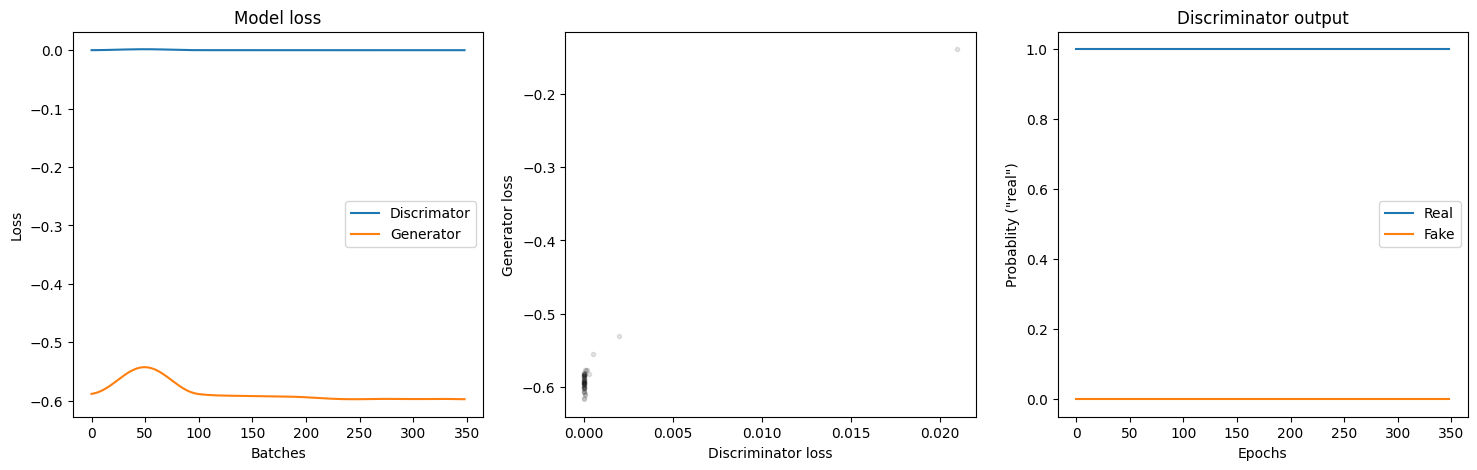

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(smooth(losses[:, 0]))
ax[0].plot(smooth(losses[:, 1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator', 'Generator'])

ax[1].plot(losses[::5, 0], losses[::5, 1], 'k.', alpha=0.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:, 0]))
ax[2].plot(smooth(disDecs[:, 1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real', 'Fake'])

plt.show()

# SINGLE NOISE SINGLE SAMPLE

In [32]:
# Generate the images from the generator network
G.eval()

noise = torch.randn(1, channels, width, height).to(device)
condition = total_img_patches_tensor[99]
condition_tensor = torch.tensor(condition, dtype=torch.float32).unsqueeze(0).to(device)
condition_tensor = condition_tensor.permute(0,3,1,2)

with torch.no_grad():
  synthetic_sample = G(noise, condition_tensor)

fake_patch = synthetic_sample.squeeze().cpu().numpy()

original_condition_np = condition_tensor.squeeze().cpu().numpy()



<ipython-input-32-9b07873e4929>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  condition_tensor = torch.tensor(condition, dtype=torch.float32).unsqueeze(0).to(device)


# 3 NOSIE 3 SAMPLE

In [39]:
# Generate the images from the generator network
G.eval()

# Generate three different noise variables
noise1 = torch.randn(1, channels, width, height).to(device)
noise2 = torch.randn(1, channels, width, height).to(device)
noise3 = torch.randn(1, channels, width, height).to(device)

# Get a single real patch
condition = total_img_patches_tensor[99]
condition_tensor = torch.tensor(condition, dtype=torch.float32).unsqueeze(0).to(device)
condition_tensor = condition_tensor.permute(0, 3, 1, 2)

with torch.no_grad():
    # Generate synthetic samples using three different noise variables
    synthetic_sample1 = G(noise1, condition_tensor)
    synthetic_sample2 = G(noise2, condition_tensor)
    synthetic_sample3 = G(noise3, condition_tensor)

# Convert synthetic samples and original condition to numpy arrays
fake_patch1 = synthetic_sample1.squeeze().cpu().numpy()
fake_patch2 = synthetic_sample2.squeeze().cpu().numpy()
fake_patch3 = synthetic_sample3.squeeze().cpu().numpy()
original_condition_np = condition_tensor.squeeze().cpu().numpy()


<ipython-input-39-97d297e10fac>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  condition_tensor = torch.tensor(condition, dtype=torch.float32).unsqueeze(0).to(device)


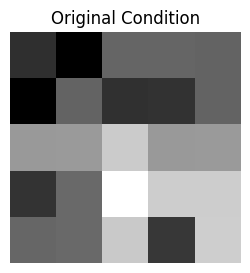

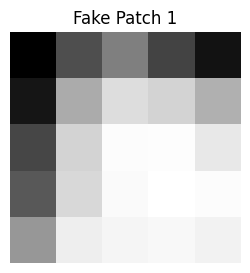

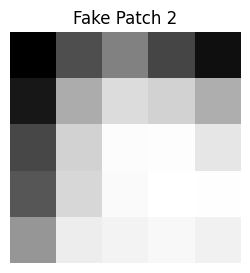

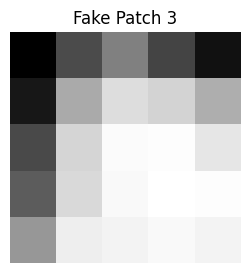

In [42]:
# Plot the original condition separately
plt.figure(figsize=(3, 3))
plt.imshow(original_condition_np[1, :, :], cmap='gray')
plt.title('Original Condition')
plt.axis('off')
plt.show()

# Plot the synthetic sample
plt.figure(figsize=(3, 3))
plt.imshow(fake_patch1[1,:,:], cmap='gray')
plt.title('Fake Patch 1')
plt.axis('off')
plt.show()

# Plot the synthetic sample
plt.figure(figsize=(3, 3))
plt.imshow(fake_patch2[1,:,:], cmap='gray')
plt.title('Fake Patch 2')
plt.axis('off')
plt.show()

# Plot the synthetic sample
plt.figure(figsize=(3, 3))
plt.imshow(fake_patch3[1,:,:], cmap='gray')
plt.title('Fake Patch 3')
plt.axis('off')
plt.show()

In [44]:
def rmse(img1, img2):
    """Calculate the Root Mean Square Error (RMSE) between two images."""
    if isinstance(img1, torch.Tensor):
        img1 = img1.cpu().detach().numpy() if img1.is_cuda else img1.detach().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.cpu().detach().numpy() if img2.is_cuda else img2.detach().numpy()
    return np.sqrt(np.mean((img1 - img2) ** 2))

def psnr(img1, img2):
    """Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images."""
    mse = rmse(img1, img2) ** 2
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Assuming pixel values are normalized between 0 and 1
    return 20 * np.log10(max_pixel / np.sqrt(mse))


In [46]:
print("PSNR: ",psnr(original_condition_np,fake_patch1))
print("RMSE: ",rmse(original_condition_np,fake_patch1))

PSNR:  7.647716557058246
RMSE:  0.41458556


In [47]:
def calculate_spectra(patch):
    patch_tensor = torch.tensor(patch).to(device)

    spectra = torch.mean(patch_tensor, dim=(1, 2))

    return spectra


<ipython-input-47-b4235962443b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch_tensor = torch.tensor(patch).to(device)


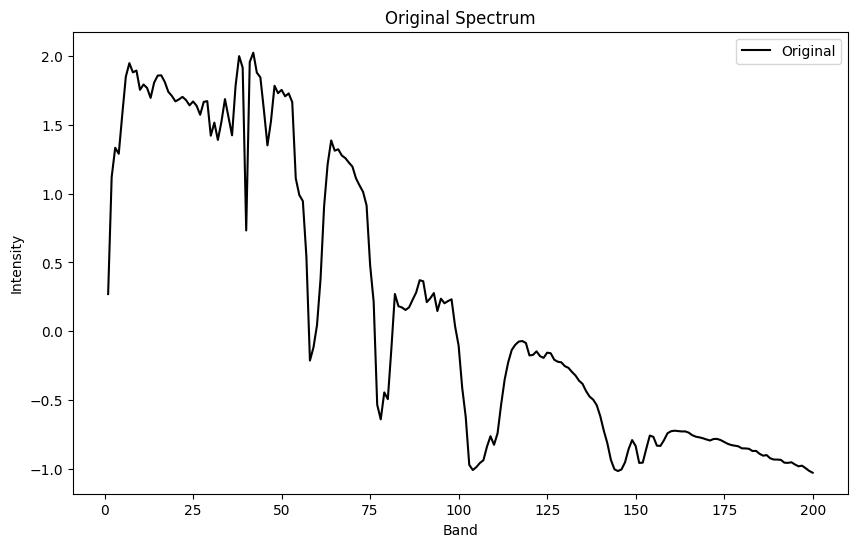

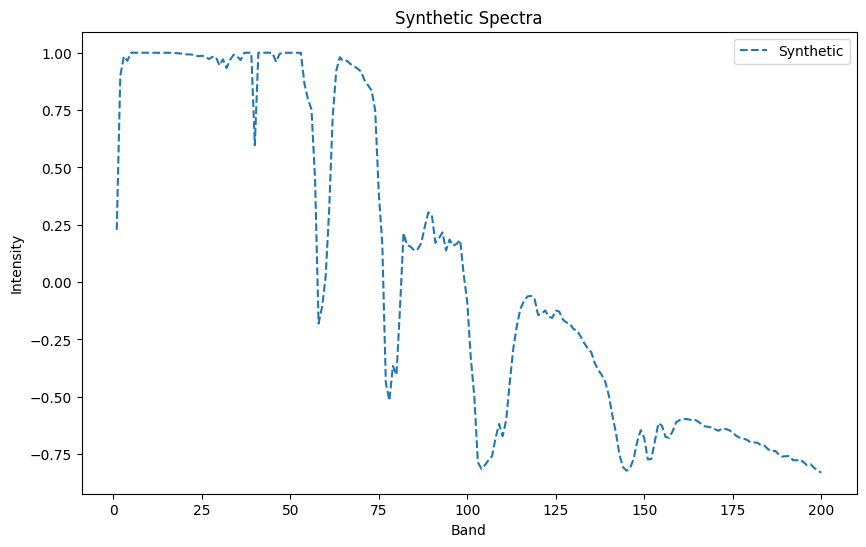

In [48]:
# Calculate spectra for original and synthetic samples
spectra_original = calculate_spectra(condition.permute(2,0,1))
spectra_synthetic_samples = calculate_spectra(fake_patch)

spectra_original_cpu = spectra_original.cpu().numpy()
spectra_synthetic_samples_cpu = spectra_synthetic_samples.cpu().numpy()

# Plot original spectrum
plt.figure(figsize=(10, 6))
bands_range_original = range(1, len(spectra_original_cpu) + 1)
plt.plot(bands_range_original, spectra_original_cpu, label='Original', color='black')
plt.xlabel('Band')
plt.ylabel('Intensity')
plt.title('Original Spectrum')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
bands_range_synthetic = range(1, len(spectra_synthetic_samples_cpu) + 1)  # Create a range covering all bands
plt.plot(bands_range_synthetic, spectra_synthetic_samples_cpu, label='Synthetic', linestyle='--')  # Plot the spectrum
plt.xlabel('Band')
plt.ylabel('Intensity')
plt.title('Synthetic Spectra')
plt.legend()
plt.show()

# Generating all fake patches

In [49]:
import numpy as np
from skimage.util import view_as_blocks

patch_size = 5

testing_total_img_patches = view_as_blocks(transformed_img_data, (patch_size, patch_size, transformed_img_data.shape[2])).squeeze()

# Reshape the patches into a 4D tensor
testing_total_img_patches = testing_total_img_patches.reshape(-1, patch_size, patch_size, transformed_img_data.shape[2])

testing_total_img_patches_tensor = torch.tensor(testing_total_img_patches, dtype=torch.float32).to(device)

print("Image Patches Shape:", testing_total_img_patches_tensor.shape)


Image Patches Shape: torch.Size([841, 5, 5, 200])


# SINGLE NOISE SINGLE PATCH

In [ ]:
G.eval()
G = G.to(device)

fake_patches = []

total_img_patches_normalized_tensor = torch.tensor(testing_total_img_patches, dtype=torch.float32).to(device)

for original_condition_tensor in total_img_patches_normalized_tensor:

    noise = torch.randn(1, channels, width, height).to(device)

    with torch.no_grad():
        synthetic_sample = G(noise, original_condition_tensor.permute(2,0,1).unsqueeze(0))

    fake_patches.append(synthetic_sample.squeeze().detach().cpu().numpy())

fake_patches = np.array(fake_patches)

# 3 NOISE 3 SAMPLE

In [50]:
G.eval()

fake_patches_1 = []  # Array to store first fake patches
fake_patches_2 = []  # Array to store second fake patches
fake_patches_3 = []  # Array to store third fake patches

total_img_patches_normalized_tensor = torch.tensor(testing_total_img_patches, dtype=torch.float32).to(device)

for original_condition_tensor in total_img_patches_normalized_tensor:
    # Generate the first fake patch
    noise_1 = torch.randn(1, channels, width, height).to(device)
    with torch.no_grad():
        synthetic_sample_1 = G(noise_1, original_condition_tensor.permute(2,0,1).unsqueeze(0))
    fake_patches_1.append(synthetic_sample_1.squeeze().detach().cpu().numpy())

    # Generate the second fake patch
    noise_2 = torch.randn(1, channels, width, height).to(device)
    with torch.no_grad():
        synthetic_sample_2 = G(noise_2, original_condition_tensor.permute(2,0,1).unsqueeze(0))
    fake_patches_2.append(synthetic_sample_2.squeeze().detach().cpu().numpy())

    # Generate the third fake patch
    noise_3 = torch.randn(1, channels, width, height).to(device)
    with torch.no_grad():
        synthetic_sample_3 = G(noise_3, original_condition_tensor.permute(2,0,1).unsqueeze(0))
    fake_patches_3.append(synthetic_sample_3.squeeze().detach().cpu().numpy())

fake_patches_1 = np.array(fake_patches_1)
fake_patches_2 = np.array(fake_patches_2)
fake_patches_3 = np.array(fake_patches_3)


In [52]:
def reconstruct_fake_image(fake_patches, original_image_shape):
    num_patches_x = original_image_shape[1] // fake_patches.shape[2]
    num_patches_y = original_image_shape[2] // fake_patches.shape[3]

    fake_patches_tensor = torch.tensor(fake_patches).to(device)

    fake_image = torch.zeros(original_image_shape).to(device)

    for i in range(num_patches_x):
        for j in range(num_patches_y):
            fake_image[:, i*fake_patches.shape[2]:(i+1)*fake_patches.shape[2],
                       j*fake_patches.shape[3]:(j+1)*fake_patches.shape[3]] = fake_patches_tensor[i * num_patches_y + j]

    return fake_image



In [53]:
original_image_shape = (channels, 145, 145)

fake_image_1 = reconstruct_fake_image(fake_patches_1, original_image_shape)
fake_image_2 = reconstruct_fake_image(fake_patches_2, original_image_shape)
fake_image_3 = reconstruct_fake_image(fake_patches_3, original_image_shape)

fake_image_1_np = fake_image_1.cpu().numpy()
fake_image_2_np = fake_image_2.cpu().numpy()
fake_image_3_np = fake_image_3.cpu().numpy()

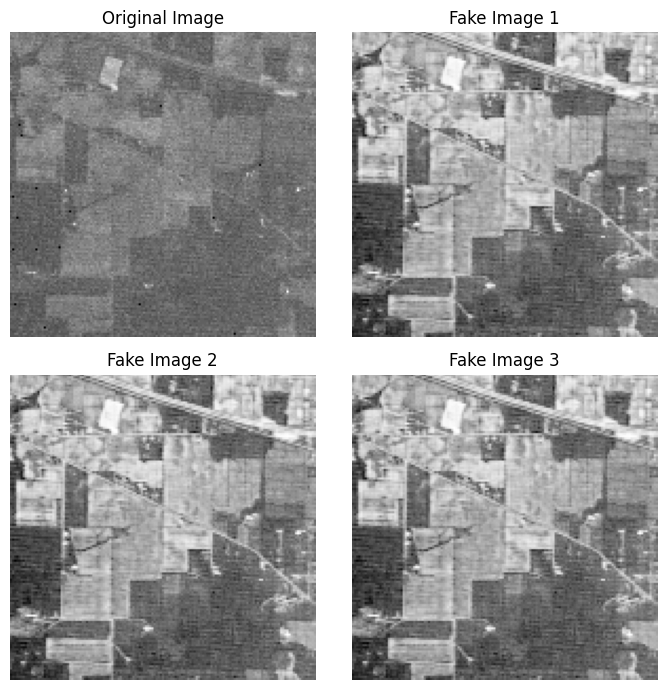

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

axs[0,0].imshow(transformed_img_data[:,:, 1], cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,0].axis('off')

axs[0,1].imshow(fake_image_1_np[1, :, :], cmap='gray')
axs[0,1].set_title('Fake Image 1')
axs[0,1].axis('off')

axs[1,0].imshow(fake_image_2_np[1, :, :], cmap='gray')
axs[1,0].set_title('Fake Image 2')
axs[1,0].axis('off')

axs[1,1].imshow(fake_image_3_np[1, :, :], cmap='gray')
axs[1,1].set_title('Fake Image 3')
axs[1,1].axis('off')

plt.tight_layout()
plt.show()

In [60]:
fake_image_1_np.shape

(200, 145, 145)

In [62]:
transformed_img_data = np.transpose(transformed_img_data, (2, 0, 1))
transformed_img_data.shape

(200, 145, 145)

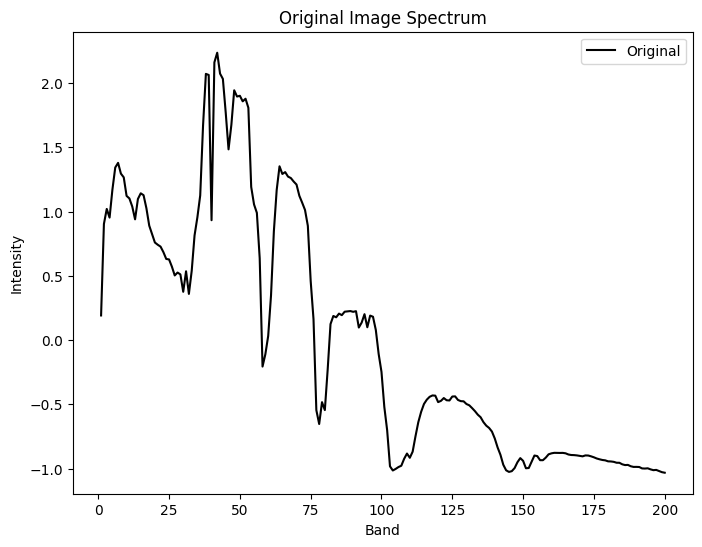

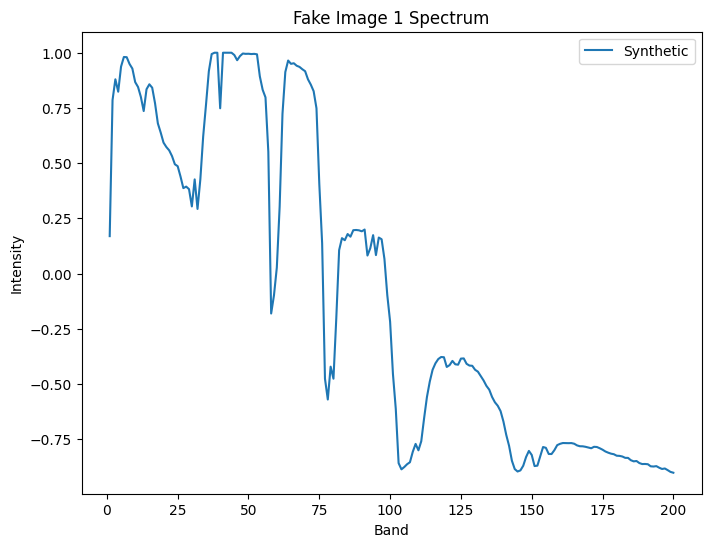

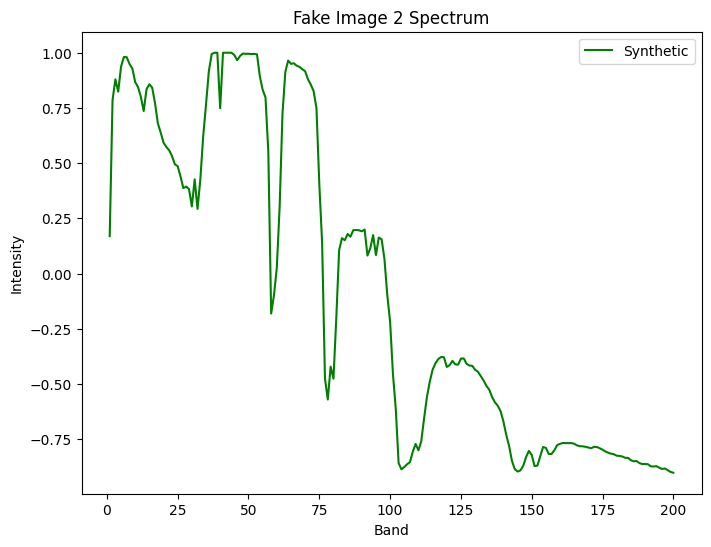

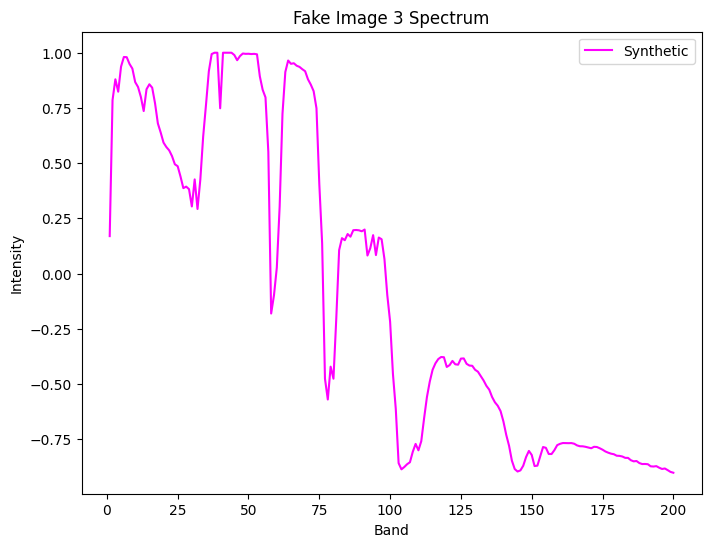

In [67]:
# Calculate spectra for original and synthetic samples
spectra_real = calculate_spectra(transformed_img_data)
spectra_fake_1 = calculate_spectra(fake_image_1_np)
spectra_fake_2 = calculate_spectra(fake_image_2_np)
spectra_fake_3 = calculate_spectra(fake_image_3_np)

spectra_real_cpu = spectra_real.cpu().numpy()
spectra_fake_1_cpu = spectra_fake_1.cpu().numpy()
spectra_fake_2_cpu = spectra_fake_2.cpu().numpy()
spectra_fake_3_cpu = spectra_fake_3.cpu().numpy()

bands_range_original = range(1, len(spectra_real_cpu) + 1)

# Plot original spectrum
plt.figure(figsize=(8, 6))
plt.plot(bands_range_original, spectra_real_cpu, label='Original', color='black')
plt.xlabel('Band')
plt.ylabel('Intensity')
plt.title('Original Image Spectrum')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(bands_range_synthetic, spectra_fake_1_cpu, label='Synthetic', linestyle='-')
plt.xlabel('Band')
plt.ylabel('Intensity')
plt.title('Fake Image 1 Spectrum')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(bands_range_synthetic, spectra_fake_2_cpu, label='Synthetic', linestyle='-', color="green")
plt.xlabel('Band')
plt.ylabel('Intensity')
plt.title('Fake Image 2 Spectrum')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(bands_range_synthetic, spectra_fake_3_cpu, label='Synthetic', linestyle='-', color="magenta")
plt.xlabel('Band')
plt.ylabel('Intensity')
plt.title('Fake Image 3 Spectrum')
plt.legend()
plt.show()

In [ ]:
spectra_real.shape

torch.Size([10])

In [68]:
import scipy.io

# Define the path to save the fake image
fake_img_1_path = "/content/drive/MyDrive/Hemanth/Dataset/fake_image_1_Indian_Pines.mat"
fake_img_2_path = "/content/drive/MyDrive/Hemanth/Dataset/fake_image_2_Indian_Pines.mat"
fake_img_3_path = "/content/drive/MyDrive/Hemanth/Dataset/fake_image_3_Indian_Pines.mat"

# Save the fake image to the specified path in MATLAB format
scipy.io.savemat(fake_img_1_path, {'fake_image': fake_image_1_np})
scipy.io.savemat(fake_img_2_path, {'fake_image': fake_image_2_np})
scipy.io.savemat(fake_img_3_path, {'fake_image': fake_image_3_np})